In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

!pip install tensorflow-addons
import tensorflow_addons as tfa
!pip install -U vit_keras
from vit_keras import vit, utils, visualize

import time
import numpy as np
from numpy import sqrt, argmax, genfromtxt
from scipy.optimize import minimize
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Conv2D, Flatten, Concatenate, ZeroPadding2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from sklearn import metrics
from sklearn.utils import compute_class_weight
from sklearn.metrics import roc_curve, auc,  precision_recall_curve, average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, cohen_kappa_score, precision_score, recall_score, classification_report, log_loss, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=a3bc86101a2b1d54b3c2f571059238e7b2589ec85f86b678de24c3f5c5251363
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = "/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train"
test_dir = "/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid"

img_width, img_height = 224,224
epochs = 100
batch_size = 16
num_classes = 4
input_shape = (img_width, img_height, 3)
model_input = Input(shape=input_shape)
print(model_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        seed=42,
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical')

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [5]:
# ground truth labels
Y_test=test_generator.classes
print(Y_test.shape)
Y_test1=to_categorical(Y_test,
                       num_classes=num_classes,
                       dtype='float32')
print(Y_test1.shape)

(400,)
(400, 4)


In [6]:
# identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_test_samples = len(test_generator.filenames)
nb_train_samples, nb_test_samples, train_generator.class_indices

(1600, 400, {'amd': 0, 'cataract': 1, 'diabetes': 2, 'normal': 3})

In [7]:
# ViT models: - B/16 model

vit_model = vit.vit_b16(
        image_size = img_width,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        weights="imagenet21k+imagenet2012",
        classes = num_classes)

vit_model.summary()
out = tf.keras.layers.Flatten()(vit_model.output)
out = tf.keras.layers.Dense(num_classes, 'softmax')(out)
model_b16 = tf.keras.Model(inputs = vit_model.input,
                        outputs = out,
                        name = 'vit_b16_retrain')
model_b16.summary()

347502902/347502902 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [8]:
# Use Calbacks and Store model#%%
filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                             verbose=1,
                             save_weights_only=False,
                             save_best_only=True,
                             mode='min',
                             save_freq='epoch')
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=1,
                              mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              verbose=1,
                              mode='min',
                              min_lr=0.00001)
callbacks_list = [checkpoint, earlyStopping, reduce_lr]
t=time.time()

In [9]:
train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes)

class_weights = dict(zip(np.unique(train_classes), class_weights))
print(class_weights)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [10]:
# Compile, Fit
sgd = SGD(learning_rate=0.0001,
          momentum=0.9)
model_b16.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
model_b16_history = model_b16.fit(train_generator,
                          steps_per_epoch=nb_train_samples // batch_size,
                          epochs=epochs,
                          validation_data=test_generator,
                          callbacks=callbacks_list,
                          class_weight = class_weights,
                          validation_steps=nb_test_samples // batch_size,
                          verbose=1)

print('Training time: %s' % (time.time()-t))

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.0155 - accuracy: 0.5581
Epoch 1: val_loss improved from inf to 0.60567, saving model to best_model.h5
100/100 [==============================] - 342s 3s/step - loss: 1.0155 - accuracy: 0.5581 - val_loss: 0.6057 - val_accuracy: 0.7675 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.5818 - accuracy: 0.7744
Epoch 2: val_loss improved from 0.60567 to 0.45132, saving model to best_model.h5
100/100 [==============================] - 119s 1s/step - loss: 0.5818 - accuracy: 0.7744 - val_loss: 0.4513 - val_accuracy: 0.8275 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.8169
Epoch 3: val_loss improved from 0.45132 to 0.36860, saving model to best_model.h5
100/100 [==============================] - 124s 1s/step - loss: 0.4685 - accuracy: 0.8169 - val_loss: 0.3686 - val_accuracy: 0.8675 - lr: 1.0000e-04
Epoch 4/100
100/100 

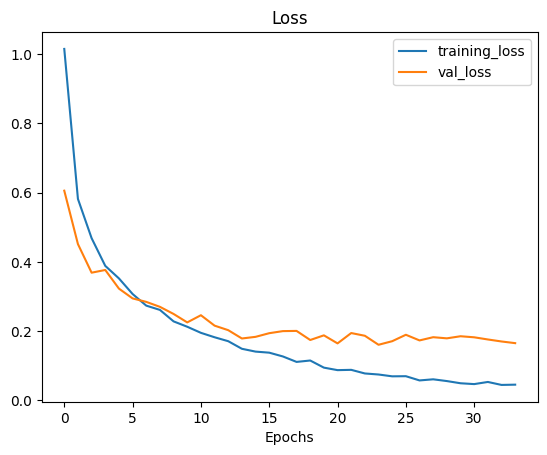

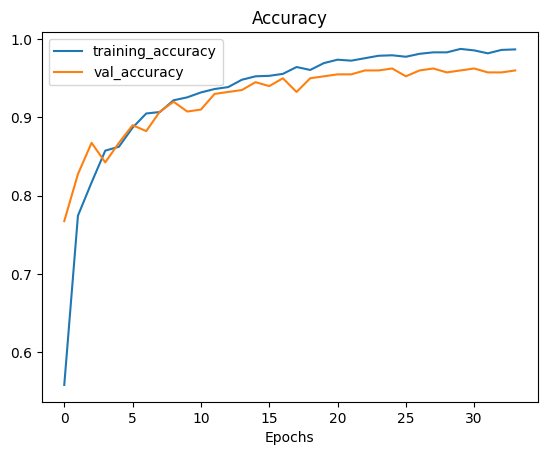

In [11]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(model_b16_history)

In [12]:
model_b16.load_weights('/content/best_model.h5')
_, accuracy = model_b16.evaluate(test_generator)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

25/25 [==============================] - 22s 864ms/step - loss: 0.1602 - accuracy: 0.9600
Validation accuracy: 96.0%


In [13]:
custom_y_pred = model_b16.predict(test_generator,
                              nb_test_samples // batch_size,
                              verbose=1)

25/25 [==============================] - 26s 934ms/step


In [14]:
# custom function to compute performance metrics
def matrix_metrix(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Kappa = 2 * (TP * TN - FN * FP) / (TP * FN + TP * FP + 2 * TP * TN + FN**2 + FN * TN + FP**2 + FP * TN)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    Recall     = round( TP / (TP+FN),4 )
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Recall','F1','MCC','Kappa'],
                            'Value':[TP,TN,FP,FN,Accuracy,Precision,Recall,F1,MCC,Kappa]})
    return (mat_met)

In [15]:
# print all metrics
mat_met = matrix_metrix(Y_test1.argmax(axis=-1),
                      custom_y_pred.argmax(axis=-1),
                      beta=0.4)
print (mat_met)

      Metric      Value
0         TP  99.000000
1         TN  98.000000
2         FP   1.000000
3         FN   1.000000
4   Accuracy   0.989900
5  Precision   0.990000
6     Recall   0.990000
7         F1   0.990000
8        MCC   0.979900
9      Kappa   0.979899


In [19]:
# print the confusion matrix
target_names = ['amd', 'cataract', 'diabetes', 'normal']
print(classification_report(Y_test1.argmax(axis=-1),
                            custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

         amd     0.9515    0.9800    0.9655       100
    cataract     0.9900    0.9900    0.9900       100
    diabetes     0.9888    0.8800    0.9312       100
      normal     0.9167    0.9900    0.9519       100

    accuracy                         0.9600       400
   macro avg     0.9617    0.9600    0.9597       400
weighted avg     0.9617    0.9600    0.9597       400



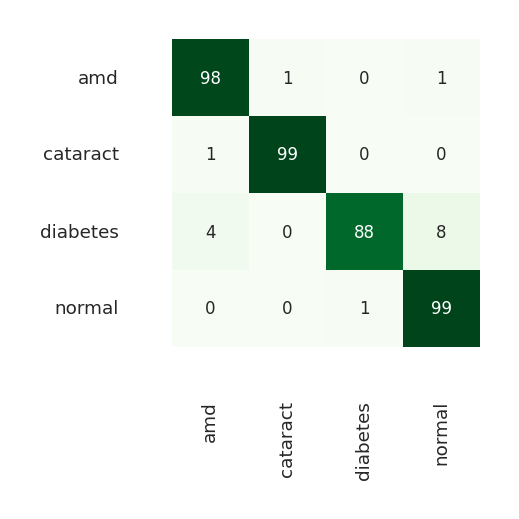

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test1.argmax(axis=-1),
                              custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=5)

x_axis_labels = ['amd', 'cataract', 'diabetes', 'normal']
y_axis_labels = ['amd', 'cataract', 'diabetes', 'normal']
plt.figure(figsize=(1,1), dpi=400)
sns.set(font_scale=0.3)
b = sns.heatmap(cnf_matrix, annot=True, square = True,
            cbar=False, cmap='Greens',
            annot_kws={'size': 3},
            fmt='g',
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels)

In [21]:
TP = cnf_matrix[0, 0]
TN = cnf_matrix[1:, 1:].sum()
FP = cnf_matrix[0, 1:].sum()
FN = cnf_matrix[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Spesificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 98
False Positives: 2
True Negatives: 295
False Negatives: 5
Spesificity: 0.9932659932659933
Sensitivity: 0.9514563106796117
